# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos/Campo 20 puntos'

## Datos de entrenamiento

### Datos

In [5]:
campvectrain = np.load(path + '/campvectrain.npy')

In [6]:
np.shape(campvectrain)

(7000, 2, 20, 20)

### Coeficientes

In [7]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [8]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
campvectest = np.load(path + '/campvectest.npy')

In [10]:
np.shape(campvectest)

(2000, 2, 20, 20)

### Coeficientes

In [11]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [12]:
np.shape(coefcampvectest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
campvecval = np.load(path + '/campvecval.npy')

In [14]:
np.shape(campvecval)

(1000, 2, 20, 20)

### Coeficienes

In [15]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [16]:
np.shape(coefcampvecval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(2, 20, 20), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 10

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [21]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(2,20,20)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(20, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(20, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(10, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(5, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7)
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 800)              3200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 20)                16020     
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 10)                210       
                                                                 
 dense_4 (Dense)             (None, 5)                 55        
                                                        

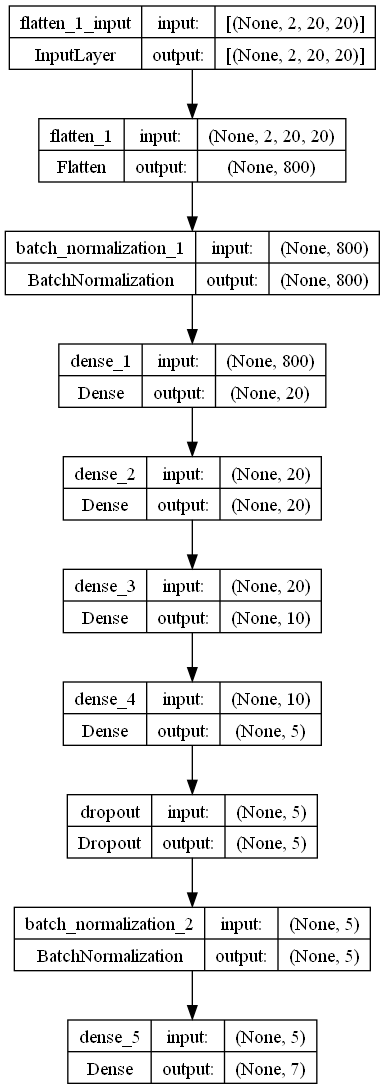

In [24]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [25]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [26]:
model.compile(optimizer=optimizer,
              loss= 'MSE',
              metrics=['mae'])

In [27]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [28]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
700/700 [==============================] - 1s 1ms/step - loss: 21.3642 - mae: 3.7112 - val_loss: 9.8602 - val_mae: 2.4404 - lr: 0.0010
Epoch 2/1000
700/700 [==============================] - 1s 853us/step - loss: 8.6233 - mae: 2.3111 - val_loss: 6.9064 - val_mae: 2.0649 - lr: 0.0010
Epoch 3/1000
700/700 [==============================] - 1s 839us/step - loss: 7.7097 - mae: 2.2074 - val_loss: 6.4150 - val_mae: 1.9867 - lr: 0.0010
Epoch 4/1000
700/700 [==============================] - 1s 879us/step - loss: 7.3247 - mae: 2.1569 - val_loss: 6.1114 - val_mae: 1.9320 - lr: 0.0010
Epoch 5/1000
700/700 [==============================] - 1s 874us/step - loss: 7.1273 - mae: 2.1313 - val_loss: 5.8498 - val_mae: 1.8876 - lr: 0.0010
Epoch 6/1000
700/700 [==============================] - 1s 908us/step - loss: 6.9407 - mae: 2.1039 - val_loss: 5.6584 - val_mae: 1.8635 - lr: 0.0010
Epoch 7/1000
700/700 [==============================] - 1s 895us/step - loss: 6.8382 - mae: 2.0892 - val_lo

Epoch 56/1000
700/700 [==============================] - 1s 857us/step - loss: 5.6282 - mae: 1.8935 - val_loss: 3.9956 - val_mae: 1.5854 - lr: 0.0010
Epoch 57/1000
700/700 [==============================] - 1s 848us/step - loss: 5.5535 - mae: 1.8789 - val_loss: 3.9653 - val_mae: 1.5767 - lr: 0.0010
Epoch 58/1000
700/700 [==============================] - 1s 833us/step - loss: 5.5392 - mae: 1.8790 - val_loss: 3.8168 - val_mae: 1.5246 - lr: 0.0010
Epoch 59/1000
700/700 [==============================] - 1s 842us/step - loss: 5.5293 - mae: 1.8766 - val_loss: 3.7763 - val_mae: 1.4976 - lr: 0.0010
Epoch 60/1000
700/700 [==============================] - 1s 839us/step - loss: 5.5559 - mae: 1.8770 - val_loss: 3.9191 - val_mae: 1.5303 - lr: 0.0010
Epoch 61/1000
700/700 [==============================] - 1s 831us/step - loss: 5.6136 - mae: 1.8915 - val_loss: 3.8001 - val_mae: 1.5208 - lr: 0.0010
Epoch 62/1000
700/700 [==============================] - 1s 831us/step - loss: 5.5364 - mae: 1.8744 

700/700 [==============================] - 1s 831us/step - loss: 5.4868 - mae: 1.8600 - val_loss: 3.6230 - val_mae: 1.4556 - lr: 0.0010
Epoch 165/1000
700/700 [==============================] - 1s 834us/step - loss: 5.4541 - mae: 1.8538 - val_loss: 3.6632 - val_mae: 1.4790 - lr: 0.0010
Epoch 166/1000
700/700 [==============================] - 1s 829us/step - loss: 5.4917 - mae: 1.8670 - val_loss: 3.5845 - val_mae: 1.4227 - lr: 0.0010
Epoch 167/1000
700/700 [==============================] - 1s 830us/step - loss: 5.4709 - mae: 1.8622 - val_loss: 3.5875 - val_mae: 1.4376 - lr: 0.0010
Epoch 168/1000
700/700 [==============================] - 1s 842us/step - loss: 5.4335 - mae: 1.8522 - val_loss: 3.7711 - val_mae: 1.5023 - lr: 0.0010
Epoch 169/1000
700/700 [==============================] - 1s 834us/step - loss: 5.4677 - mae: 1.8575 - val_loss: 3.6341 - val_mae: 1.4625 - lr: 0.0010
Epoch 170/1000
700/700 [==============================] - 1s 862us/step - loss: 5.4037 - mae: 1.8443 - val_lo

700/700 [==============================] - 1s 855us/step - loss: 5.4383 - mae: 1.8446 - val_loss: 3.7263 - val_mae: 1.4901 - lr: 0.0010
Epoch 273/1000
700/700 [==============================] - 1s 839us/step - loss: 5.4166 - mae: 1.8438 - val_loss: 3.6895 - val_mae: 1.4910 - lr: 0.0010
Epoch 274/1000
700/700 [==============================] - 1s 861us/step - loss: 5.4239 - mae: 1.8428 - val_loss: 3.8391 - val_mae: 1.5429 - lr: 0.0010
Epoch 275/1000
700/700 [==============================] - 1s 841us/step - loss: 5.4510 - mae: 1.8513 - val_loss: 3.8737 - val_mae: 1.5540 - lr: 0.0010
Epoch 276/1000
700/700 [==============================] - 1s 864us/step - loss: 5.3998 - mae: 1.8384 - val_loss: 3.7948 - val_mae: 1.5152 - lr: 0.0010
Epoch 277/1000
700/700 [==============================] - 1s 840us/step - loss: 5.5219 - mae: 1.8604 - val_loss: 3.6572 - val_mae: 1.4677 - lr: 0.0010
Epoch 278/1000
700/700 [==============================] - 1s 845us/step - loss: 5.4446 - mae: 1.8460 - val_lo

700/700 [==============================] - 1s 826us/step - loss: 5.3829 - mae: 1.8289 - val_loss: 3.6787 - val_mae: 1.4797 - lr: 0.0010
Epoch 381/1000
700/700 [==============================] - 1s 825us/step - loss: 5.3796 - mae: 1.8311 - val_loss: 3.8935 - val_mae: 1.5692 - lr: 0.0010
Epoch 382/1000
700/700 [==============================] - 1s 830us/step - loss: 5.4350 - mae: 1.8411 - val_loss: 3.7815 - val_mae: 1.5111 - lr: 0.0010
Epoch 383/1000
700/700 [==============================] - 1s 821us/step - loss: 5.4032 - mae: 1.8358 - val_loss: 3.8838 - val_mae: 1.5748 - lr: 0.0010
Epoch 384/1000
700/700 [==============================] - 1s 824us/step - loss: 5.4243 - mae: 1.8427 - val_loss: 3.6117 - val_mae: 1.4561 - lr: 0.0010
Epoch 385/1000
700/700 [==============================] - 1s 828us/step - loss: 5.4522 - mae: 1.8461 - val_loss: 3.6889 - val_mae: 1.4918 - lr: 0.0010
Epoch 386/1000
700/700 [==============================] - 1s 823us/step - loss: 5.4151 - mae: 1.8389 - val_lo

Epoch 486/1000
700/700 [==============================] - 1s 835us/step - loss: 5.4126 - mae: 1.8357 - val_loss: 3.6433 - val_mae: 1.4657 - lr: 8.5975e-04
Epoch 487/1000
700/700 [==============================] - 1s 831us/step - loss: 5.4193 - mae: 1.8376 - val_loss: 3.8275 - val_mae: 1.5509 - lr: 8.5810e-04
Epoch 488/1000
700/700 [==============================] - 1s 840us/step - loss: 5.3726 - mae: 1.8234 - val_loss: 3.7123 - val_mae: 1.5039 - lr: 8.5645e-04
Epoch 489/1000
700/700 [==============================] - 1s 842us/step - loss: 5.3917 - mae: 1.8267 - val_loss: 3.7983 - val_mae: 1.5472 - lr: 8.5480e-04
Epoch 490/1000
700/700 [==============================] - 1s 831us/step - loss: 5.3898 - mae: 1.8341 - val_loss: 3.6115 - val_mae: 1.4526 - lr: 8.5315e-04
Epoch 491/1000
700/700 [==============================] - 1s 828us/step - loss: 5.3832 - mae: 1.8296 - val_loss: 3.7041 - val_mae: 1.5135 - lr: 8.5150e-04
Epoch 492/1000
700/700 [==============================] - 1s 830us/ste

Epoch 539/1000
700/700 [==============================] - 1s 857us/step - loss: 5.3979 - mae: 1.8269 - val_loss: 3.6339 - val_mae: 1.4587 - lr: 7.7230e-04
Epoch 540/1000
700/700 [==============================] - 1s 852us/step - loss: 5.4580 - mae: 1.8409 - val_loss: 3.6074 - val_mae: 1.4549 - lr: 7.7065e-04
Epoch 541/1000
700/700 [==============================] - 1s 850us/step - loss: 5.4126 - mae: 1.8291 - val_loss: 3.5866 - val_mae: 1.4382 - lr: 7.6900e-04
Epoch 542/1000
700/700 [==============================] - 1s 851us/step - loss: 5.4073 - mae: 1.8333 - val_loss: 3.7989 - val_mae: 1.5486 - lr: 7.6735e-04
Epoch 543/1000
700/700 [==============================] - 1s 860us/step - loss: 5.3850 - mae: 1.8296 - val_loss: 3.6842 - val_mae: 1.4961 - lr: 7.6570e-04
Epoch 544/1000
700/700 [==============================] - 1s 843us/step - loss: 5.4071 - mae: 1.8340 - val_loss: 3.6874 - val_mae: 1.4843 - lr: 7.6405e-04
Epoch 545/1000
700/700 [==============================] - 1s 858us/ste

Epoch 592/1000
700/700 [==============================] - 1s 823us/step - loss: 5.3211 - mae: 1.8080 - val_loss: 3.5527 - val_mae: 1.4410 - lr: 6.8485e-04
Epoch 593/1000
700/700 [==============================] - 1s 830us/step - loss: 5.3768 - mae: 1.8253 - val_loss: 3.4897 - val_mae: 1.4103 - lr: 6.8320e-04
Epoch 594/1000
700/700 [==============================] - 1s 842us/step - loss: 5.3838 - mae: 1.8241 - val_loss: 3.6834 - val_mae: 1.4856 - lr: 6.8155e-04
Epoch 595/1000
700/700 [==============================] - 1s 833us/step - loss: 5.3598 - mae: 1.8180 - val_loss: 3.6176 - val_mae: 1.4698 - lr: 6.7990e-04
Epoch 596/1000
700/700 [==============================] - 1s 830us/step - loss: 5.3545 - mae: 1.8168 - val_loss: 3.6402 - val_mae: 1.4606 - lr: 6.7825e-04
Epoch 597/1000
700/700 [==============================] - 1s 830us/step - loss: 5.4051 - mae: 1.8265 - val_loss: 3.5860 - val_mae: 1.4559 - lr: 6.7660e-04
Epoch 598/1000
700/700 [==============================] - 1s 829us/ste

Epoch 645/1000
700/700 [==============================] - 1s 834us/step - loss: 5.3471 - mae: 1.8199 - val_loss: 3.6654 - val_mae: 1.4817 - lr: 5.9740e-04
Epoch 646/1000
700/700 [==============================] - 1s 854us/step - loss: 5.3228 - mae: 1.8105 - val_loss: 3.4619 - val_mae: 1.3907 - lr: 5.9575e-04
Epoch 647/1000
700/700 [==============================] - 1s 840us/step - loss: 5.3576 - mae: 1.8156 - val_loss: 3.6493 - val_mae: 1.4881 - lr: 5.9410e-04
Epoch 648/1000
700/700 [==============================] - 1s 837us/step - loss: 5.3684 - mae: 1.8137 - val_loss: 3.7584 - val_mae: 1.5275 - lr: 5.9245e-04
Epoch 649/1000
700/700 [==============================] - 1s 858us/step - loss: 5.3890 - mae: 1.8212 - val_loss: 3.6266 - val_mae: 1.4707 - lr: 5.9080e-04
Epoch 650/1000
700/700 [==============================] - 1s 838us/step - loss: 5.4162 - mae: 1.8242 - val_loss: 3.8105 - val_mae: 1.5522 - lr: 5.8915e-04
Epoch 651/1000
700/700 [==============================] - 1s 831us/ste

Epoch 698/1000
700/700 [==============================] - 1s 864us/step - loss: 5.2921 - mae: 1.8005 - val_loss: 3.4831 - val_mae: 1.4142 - lr: 5.0995e-04
Epoch 699/1000
700/700 [==============================] - 1s 847us/step - loss: 5.3540 - mae: 1.8113 - val_loss: 3.5485 - val_mae: 1.4533 - lr: 5.0830e-04
Epoch 700/1000
700/700 [==============================] - 1s 847us/step - loss: 5.3231 - mae: 1.8076 - val_loss: 3.5542 - val_mae: 1.4538 - lr: 5.0665e-04
Epoch 701/1000
700/700 [==============================] - 1s 840us/step - loss: 5.3915 - mae: 1.8221 - val_loss: 3.5359 - val_mae: 1.4402 - lr: 5.0500e-04
Epoch 702/1000
700/700 [==============================] - 1s 839us/step - loss: 5.3899 - mae: 1.8208 - val_loss: 3.5998 - val_mae: 1.4632 - lr: 5.0335e-04
Epoch 703/1000
700/700 [==============================] - 1s 847us/step - loss: 5.3629 - mae: 1.8132 - val_loss: 3.5729 - val_mae: 1.4391 - lr: 5.0170e-04
Epoch 704/1000
700/700 [==============================] - 1s 847us/ste

Epoch 751/1000
700/700 [==============================] - 1s 846us/step - loss: 5.3394 - mae: 1.8082 - val_loss: 3.5684 - val_mae: 1.4391 - lr: 4.2250e-04
Epoch 752/1000
700/700 [==============================] - 1s 840us/step - loss: 5.3302 - mae: 1.8042 - val_loss: 3.6411 - val_mae: 1.4750 - lr: 4.2085e-04
Epoch 753/1000
700/700 [==============================] - 1s 839us/step - loss: 5.3698 - mae: 1.8152 - val_loss: 3.5409 - val_mae: 1.4394 - lr: 4.1920e-04
Epoch 754/1000
700/700 [==============================] - 1s 836us/step - loss: 5.3511 - mae: 1.8129 - val_loss: 3.4682 - val_mae: 1.4063 - lr: 4.1755e-04
Epoch 755/1000
700/700 [==============================] - 1s 838us/step - loss: 5.3477 - mae: 1.8108 - val_loss: 3.5361 - val_mae: 1.4403 - lr: 4.1590e-04
Epoch 756/1000
700/700 [==============================] - 1s 841us/step - loss: 5.3042 - mae: 1.8009 - val_loss: 3.5097 - val_mae: 1.4218 - lr: 4.1425e-04
Epoch 757/1000
700/700 [==============================] - 1s 841us/ste

Epoch 804/1000
700/700 [==============================] - 1s 848us/step - loss: 5.3338 - mae: 1.8092 - val_loss: 3.6358 - val_mae: 1.4891 - lr: 3.3505e-04
Epoch 805/1000
700/700 [==============================] - 1s 848us/step - loss: 5.3817 - mae: 1.8170 - val_loss: 3.6189 - val_mae: 1.4685 - lr: 3.3340e-04
Epoch 806/1000
700/700 [==============================] - 1s 844us/step - loss: 5.3679 - mae: 1.8155 - val_loss: 3.4541 - val_mae: 1.3997 - lr: 3.3175e-04
Epoch 807/1000
700/700 [==============================] - 1s 845us/step - loss: 5.4091 - mae: 1.8239 - val_loss: 3.5852 - val_mae: 1.4578 - lr: 3.3010e-04
Epoch 808/1000
700/700 [==============================] - 1s 848us/step - loss: 5.3287 - mae: 1.8040 - val_loss: 3.5432 - val_mae: 1.4418 - lr: 3.2845e-04
Epoch 809/1000
700/700 [==============================] - 1s 835us/step - loss: 5.3281 - mae: 1.8076 - val_loss: 3.5349 - val_mae: 1.4237 - lr: 3.2680e-04
Epoch 810/1000
700/700 [==============================] - 1s 853us/ste

Epoch 857/1000
700/700 [==============================] - 1s 841us/step - loss: 5.3141 - mae: 1.8011 - val_loss: 3.5347 - val_mae: 1.4407 - lr: 2.4760e-04
Epoch 858/1000
700/700 [==============================] - 1s 842us/step - loss: 5.3619 - mae: 1.8170 - val_loss: 3.4926 - val_mae: 1.4182 - lr: 2.4595e-04
Epoch 859/1000
700/700 [==============================] - 1s 839us/step - loss: 5.3380 - mae: 1.8081 - val_loss: 3.5433 - val_mae: 1.4429 - lr: 2.4430e-04
Epoch 860/1000
700/700 [==============================] - 1s 840us/step - loss: 5.3857 - mae: 1.8181 - val_loss: 3.5738 - val_mae: 1.4532 - lr: 2.4265e-04
Epoch 861/1000
700/700 [==============================] - 1s 840us/step - loss: 5.3380 - mae: 1.8087 - val_loss: 3.5315 - val_mae: 1.4362 - lr: 2.4100e-04
Epoch 862/1000
700/700 [==============================] - 1s 836us/step - loss: 5.3083 - mae: 1.7996 - val_loss: 3.5646 - val_mae: 1.4525 - lr: 2.3935e-04
Epoch 863/1000
700/700 [==============================] - 1s 834us/ste

Epoch 910/1000
700/700 [==============================] - 1s 849us/step - loss: 5.3071 - mae: 1.7992 - val_loss: 3.4887 - val_mae: 1.4211 - lr: 1.6015e-04
Epoch 911/1000
700/700 [==============================] - 1s 841us/step - loss: 5.3459 - mae: 1.8080 - val_loss: 3.4531 - val_mae: 1.4036 - lr: 1.5850e-04
Epoch 912/1000
700/700 [==============================] - 1s 842us/step - loss: 5.3207 - mae: 1.8020 - val_loss: 3.4253 - val_mae: 1.3872 - lr: 1.5685e-04
Epoch 913/1000
700/700 [==============================] - 1s 840us/step - loss: 5.3039 - mae: 1.8042 - val_loss: 3.5166 - val_mae: 1.4290 - lr: 1.5520e-04
Epoch 914/1000
700/700 [==============================] - 1s 846us/step - loss: 5.3219 - mae: 1.8010 - val_loss: 3.4554 - val_mae: 1.4028 - lr: 1.5355e-04
Epoch 915/1000
700/700 [==============================] - 1s 843us/step - loss: 5.3297 - mae: 1.8060 - val_loss: 3.5747 - val_mae: 1.4653 - lr: 1.5190e-04
Epoch 916/1000
700/700 [==============================] - 1s 841us/ste

Epoch 963/1000
700/700 [==============================] - 1s 851us/step - loss: 5.3475 - mae: 1.8076 - val_loss: 3.5039 - val_mae: 1.4236 - lr: 7.2700e-05
Epoch 964/1000
700/700 [==============================] - 1s 846us/step - loss: 5.2758 - mae: 1.7954 - val_loss: 3.5109 - val_mae: 1.4372 - lr: 7.1050e-05
Epoch 965/1000
700/700 [==============================] - 1s 858us/step - loss: 5.3031 - mae: 1.8043 - val_loss: 3.4446 - val_mae: 1.4113 - lr: 6.9400e-05
Epoch 966/1000
700/700 [==============================] - 1s 851us/step - loss: 5.3026 - mae: 1.8026 - val_loss: 3.4938 - val_mae: 1.4280 - lr: 6.7750e-05
Epoch 967/1000
700/700 [==============================] - 1s 851us/step - loss: 5.3426 - mae: 1.8088 - val_loss: 3.4784 - val_mae: 1.4166 - lr: 6.6100e-05
Epoch 968/1000
700/700 [==============================] - 1s 858us/step - loss: 5.2982 - mae: 1.7959 - val_loss: 3.5022 - val_mae: 1.4324 - lr: 6.4450e-05
Epoch 969/1000
700/700 [==============================] - 1s 850us/ste

# Analizamos accuracy y loss

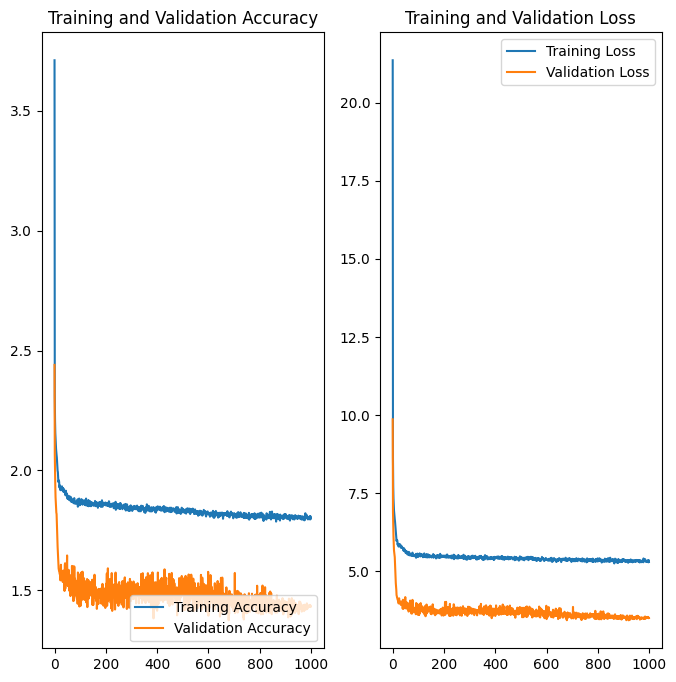

In [29]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(val_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluamos el modelo

In [33]:
test_loss, test_acc = model.evaluate(campvecval,coefcampvecval)

32/32 [==============================] - 0s 643us/step - loss: 3.4968 - mae: 1.4327


In [34]:
predictions = model.predict(campvecval)

32/32 [==============================] - 0s 531us/step


In [35]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefcampvecval, predictions)

# Calcula la desviación estándar del error
error = coefcampvecval - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 1.43272699118512, Desviación estándar del error: 1.8636924451908619, Error absoluto máximo: 6.222684860229492


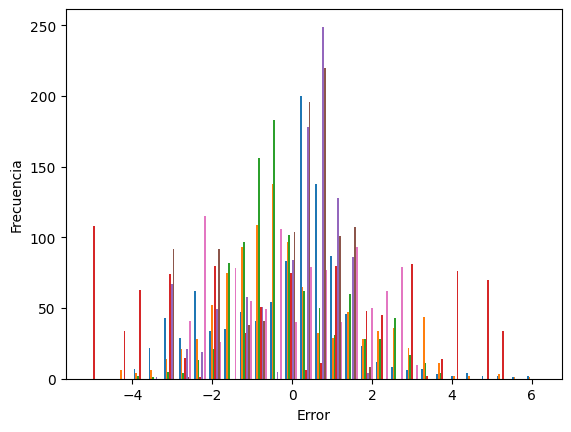

In [36]:
import matplotlib.pyplot as plt

plt.hist(error, bins=30)
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

In [37]:
from sklearn.metrics import r2_score

r2 = r2_score(coefcampvecval, predictions)
r2

0.5624386569067449

In [38]:
error_percentile_90 = np.percentile(np.abs(error), 90)
error_percentile_90

3.049589204788208

# Guardamos los datos Accuracy y Loss

In [39]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 20,50/historycampvec20.csv', index=False)

# Guardamos el modelo

In [40]:
path_to_save = '../../../Modelos/Modelos 20,50/'

In [41]:
model.save(path_to_save + '/campovectorial20.h5')

# Importamos el modelo

In [42]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [43]:
import keras
import tensorflow as tf
custom_objects = {'custom_activation': custom_activation}
new_model = keras.models.load_model('../../../Modelos/Modelos 20,50/campovectorial20.h5', custom_objects= custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [53]:
import random
from scipy.integrate import solve_ivp

campvec = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos = 10

    y1 = np.linspace(x_range_neg, x_range_pos, 20)
    y2 = np.linspace(y_range_neg, y_range_pos, 20)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)
    contador = contador+1
    print(contador)
    
campvec = np.array(campvec)
coef = np.array(coef)

--------------------------------------------
[7, 10, 5, 6, 5, 7, 2]
1


In [54]:
campvecnone = campvec[None, :]

## Predecimos con los datos nuevos

In [55]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 11ms/step
[[7. 7. 5. 5. 5. 6. 3.]]


## Encontramos puntos de equilibrio datos reales

In [56]:
from scipy.optimize import fsolve
# Sistema de ecuaciones
def system(Y):
    X, Y = Y
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1
    return [dX_dt, dY_dt]

# Adivinanza inicial para X, Y
initial_guess = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_reales = fsolve(system, initial_guess)
primer_cuadrante_reales = tuple(primer_cuadrante_reales)


print(primer_cuadrante_reales)

(1.6304853211753707, 1.1047676899208392)


## Graficamos con los coeficientes reales

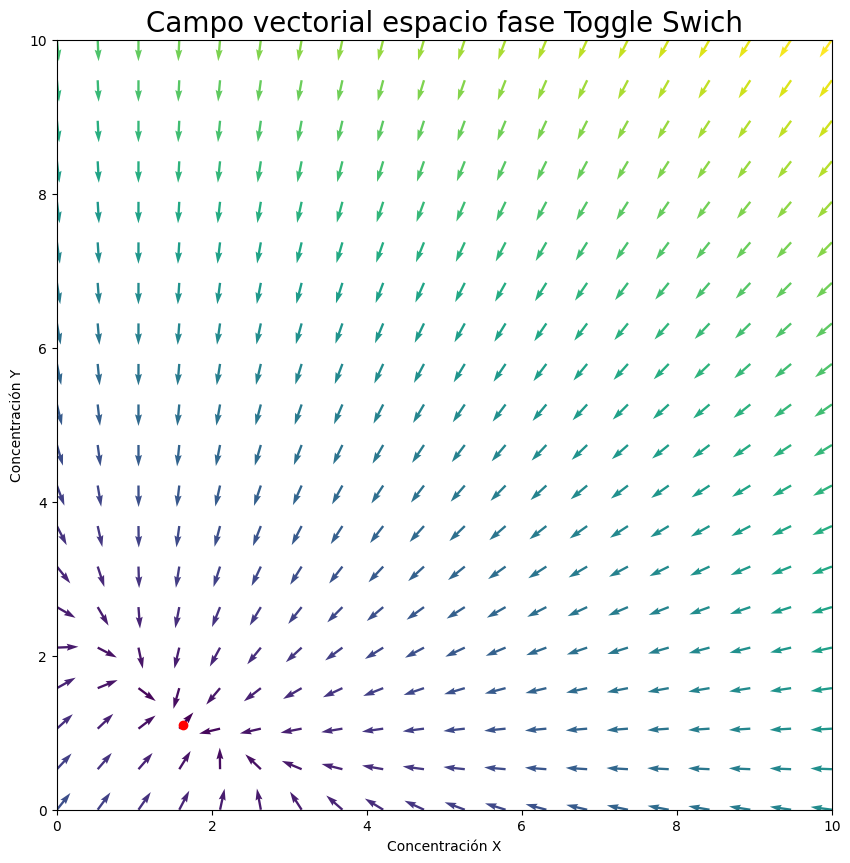

In [57]:
import matplotlib.pyplot as plt

x_values = primer_cuadrante_reales[0]
y_values =primer_cuadrante_reales[1]

y1 = np.linspace(0, 10, 20)
y2 = np.linspace(0, 10, 20)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.scatter(x_values, y_values, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')
plt.show()

## Encontramos puntos de equilibro datos predecidos

In [58]:
a1pred = new_predictions[0,0]
a2pred = new_predictions[0,1]
b1pred = new_predictions[0,2]
b2pred = new_predictions[0,3]
d1pred = new_predictions[0,4]
d2pred = new_predictions[0,5]
npred = new_predictions[0,6]

def systempred(Ypred):
    Xpred, Ypred = Ypred
    dXpred_dt = a1pred/(1+Ypred**npred)-d1pred*Xpred+b1pred
    dYpred_dt = a2pred/(1+Xpred**npred)-d2pred*Ypred+b1pred
    return [dXpred_dt, dYpred_dt]

# Adivinanza inicial para X, Y
initial_guesspred = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_predecidos = fsolve(systempred, initial_guesspred)
primer_cuadrante_predecidos = tuple(primer_cuadrante_predecidos)


print(primer_cuadrante_predecidos)

(1.6545103200181221, 1.0443395186285904)


## Graficamos con los coeficientes predecidos

Text(0, 0.5, 'Concentración Y')

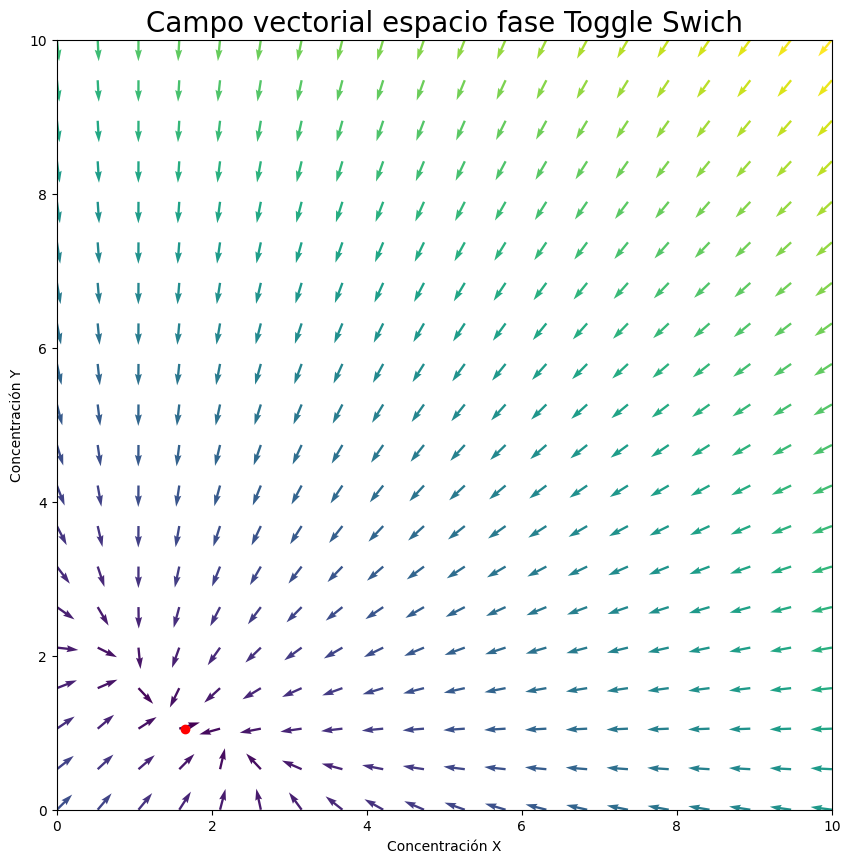

In [59]:
import matplotlib.pyplot as plt

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1pred/(1+Y**npred)-d1pred*X+b1pred
    dY_dt = a2pred/(1+X**npred)-d2pred*Y+b1pred

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 10
y_range_neg = 0
y_range_pos = 10

y1pred = np.linspace(x_range_neg, x_range_pos, 20)
y2pred = np.linspace(y_range_neg, y_range_pos, 20)

Y1pred, Y2pred = np.meshgrid(y1pred, y2pred)
    
t1 = 0

upred, vpred = np.zeros(Y1pred.shape), np.zeros(Y2pred.shape)

NI, NJ = Y1.shape

u1pred, v1pred = f(t1, [Y1, Y2])
upred, vpred = f(t1, [Y1, Y2])
Mpred = (np.hypot(upred, vpred))
upred /= Mpred
vpred /= Mpred


x_valuespred = primer_cuadrante_predecidos[0]
y_valuespred =primer_cuadrante_predecidos[1]
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.scatter(x_valuespred, y_valuespred, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Graficamos ambos

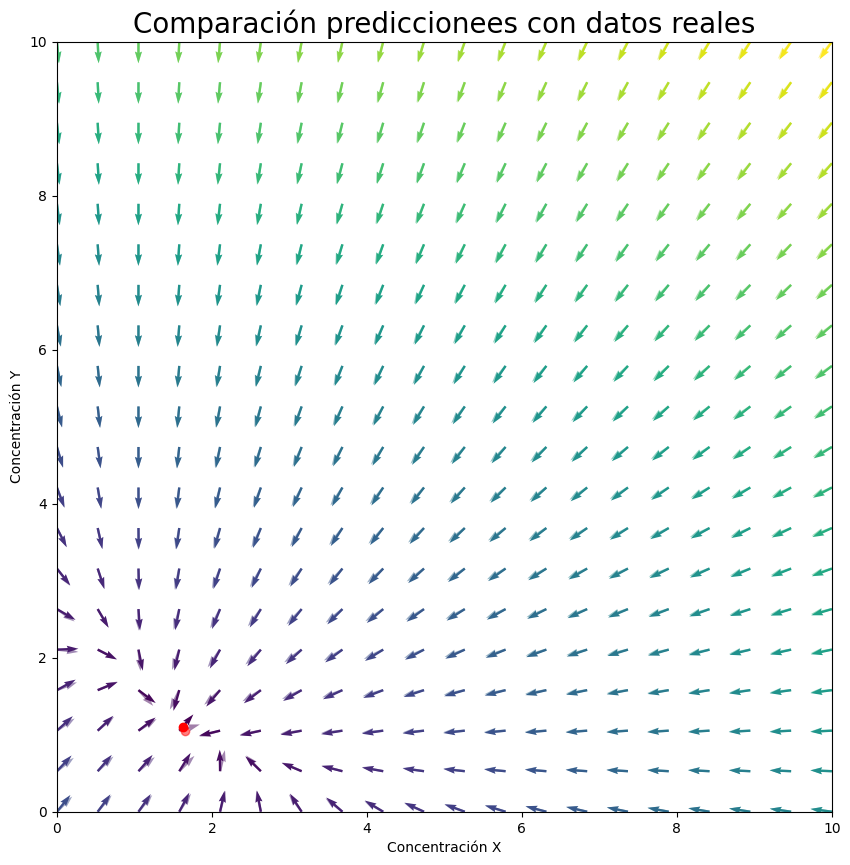

In [60]:
fig, ax = plt.subplots(figsize=(10, 10))

# Primero graficamos la predicción, que debería ser más clara (alpha < 1)
Q = ax.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy', alpha=0.5)

# Luego, graficamos los datos originales, que serán más oscuros (alpha = 1)
Q1 = ax.quiver(Y1, Y2, u, v, M, angles='xy', alpha=1)

ax.scatter(x_valuespred, y_valuespred, color='red', alpha = 0.5)
ax.scatter(x_values, y_values, color='red', alpha = 1)
ax.set_title('Comparación prediccionees con datos reales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

plt.show()

## Graficamos las diferencias

16.7070229594969


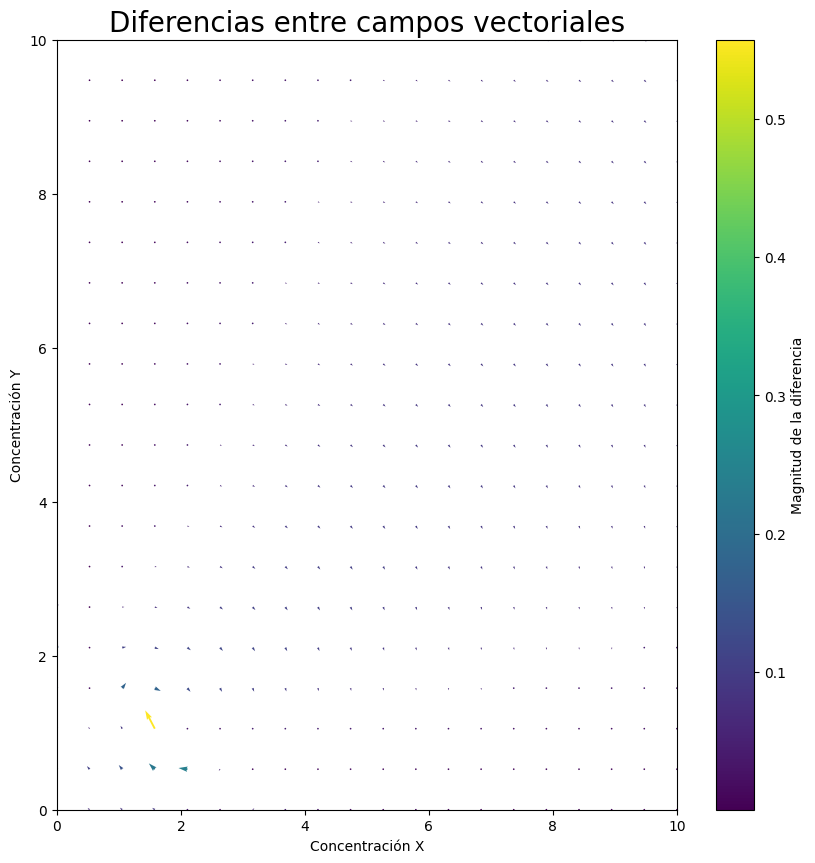

In [61]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Ahora calculamos la magnitud
#M_diff = np.hypot(u_diff2, v_diff2)
M_diff = np.hypot(u_diff, v_diff)

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30
print(rango)
# Escala para las flechas. Aumenta este valor si las flechas son demasiado grandes.

# Graficamos las diferencias
#Q = ax.quiver(Y1, Y2, u_diff2, v_diff2, M_diff, angles='xy')
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy', scale = rango)
#Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy')


ax.set_title('Diferencias entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia')

plt.show()

## Errores relativos

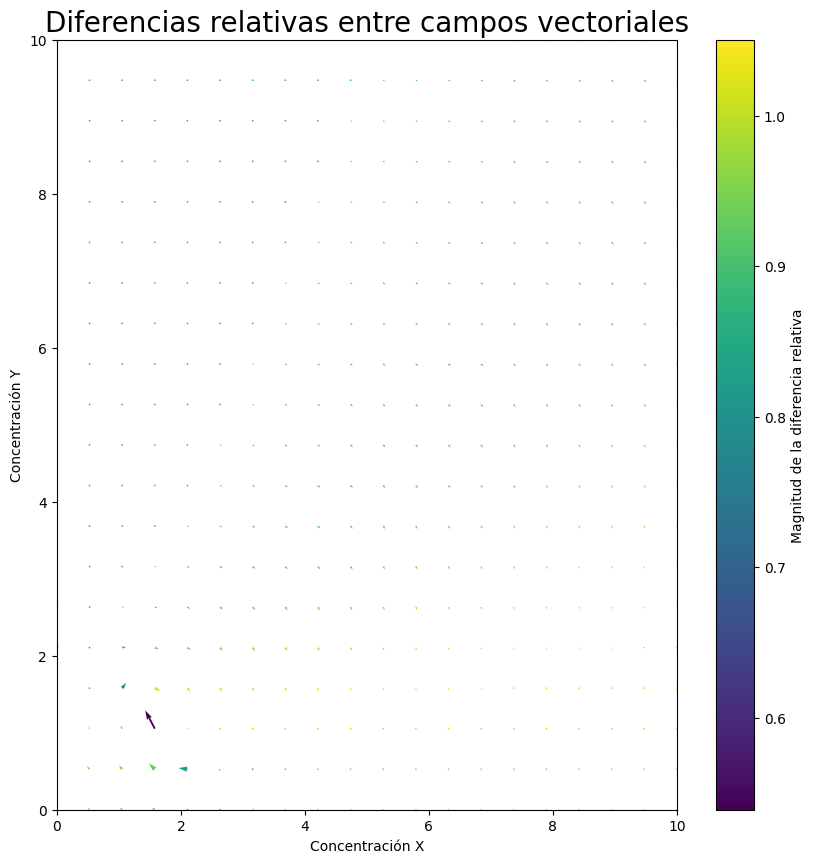

In [62]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7

# Calculamos la magnitud del vector original y de la diferencia
M_orig = np.hypot(u1, v1) + epsilon
M_diff = np.hypot(u1pred, v1pred)

# Calculamos la diferencia relativa
M_diff_rel = M_diff / M_orig

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30

# Graficamos las diferencias relativas
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff_rel, angles='xy', scale = rango)

ax.set_title('Diferencias relativas entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia relativa')

plt.show()

In [63]:
max_index_flattened = M_diff_rel.argmax()
max_coords = np.unravel_index(max_index_flattened, M_diff_rel.shape)
M_orig[max_coords]
print('El valor máximo de error relativo es de:', M_diff_rel.max() )
print('El valor de u1 en el error relativo máximo es:',u1[max_coords])
print('El valor de u1pred en el error relativo máximo es:',u1pred[max_coords])
print('El valor de v1 en el error relativo máximo es:',v1[max_coords])
print('El valor de v1pred en el error relativo máximo es:',v1pred[max_coords])

El valor máximo de error relativo es de: 1.0503848090815158
El valor de u1 en el error relativo máximo es: -2.2056850404592288
El valor de u1pred en el error relativo máximo es: -2.295075463745169
El valor de v1 en el error relativo máximo es: -0.5275235513567189
El valor de v1pred en el error relativo máximo es: -0.6382044103894984
